In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900


In [4]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [5]:
data = data.drop(["Volume"],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")

#hai widha

In [6]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    """
    Mengubah data time series menjadi data supervised learning.

    Argumen:
    data: DataFrame, dataset time series yang akan diubah.
    n_in: int, jumlah timestep mundur sebagai input (X).
    n_out: int, jumlah timestep maju sebagai output (y).
    dropnan: bool, apakah akan menghapus baris dengan nilai NaN.
    var_names: list of str, nama variabel untuk setiap kolom.

    Returns:
    DataFrame yang sudah diubah menjadi format supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]
    
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]
    
    # Concatenate semua kolom
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Contoh penggunaan:
# Misalkan 'data' adalah DataFrame yang berisi data time series
# dengan tiga fitur, dan kita ingin menggunakan 3 timestep mundur sebagai input
# dan 1 timestep maju sebagai output, dan nama variabel untuk setiap fitur adalah
# 'A', 'B', dan 'C'

var_names = data.columns
data_supervised = time_series_to_supervised(data, n_in=15, n_out=1, var_names=var_names)


In [7]:
train_data = data_supervised[:lengh_train]
validation_data = data_supervised[lengh_train:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data train
scaled_train_data = scaler.fit_transform(train_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)



In [9]:
y_train_scaled = scaled_train_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)

In [10]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 75 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open(t-15)       255 non-null    float64
 1   High(t-15)       255 non-null    float64
 2   Low(t-15)        255 non-null    float64
 3   Close(t-15)      255 non-null    float64
 4   Adj Close(t-15)  255 non-null    float64
 5   Open(t-14)       255 non-null    float64
 6   High(t-14)       255 non-null    float64
 7   Low(t-14)        255 non-null    float64
 8   Close(t-14)      255 non-null    float64
 9   Adj Close(t-14)  255 non-null    float64
 10  Open(t-13)       255 non-null    float64
 11  High(t-13)       255 non-null    float64
 12  Low(t-13)        255 non-null    float64
 13  Close(t-13)      255 non-null    float64
 14  Adj Close(t-13)  255 non-null    float64
 15  Open(t-12)       255 non-null    float64
 16  High(t-12)       255 non-null    float64
 17  Low(t-12)       

In [11]:
y_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open(t)  255 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [12]:
X_train_scaled

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Open(t-14),High(t-14),Low(t-14),Close(t-14),Adj Close(t-14),...,Open(t-2),High(t-2),Low(t-2),Close(t-2),Adj Close(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Adj Close(t-1)
0,0.326005,0.309047,0.313632,0.297243,0.297243,0.291232,0.229312,0.245304,0.234413,0.234413,...,0.351624,0.299820,0.347459,0.359248,0.359248,0.351924,0.365283,0.366145,0.406821,0.406821
1,0.314588,0.239222,0.268654,0.234413,0.234413,0.229634,0.242574,0.186888,0.310395,0.310395,...,0.351924,0.365283,0.366145,0.406821,0.406821,0.398577,0.355807,0.334783,0.311713,0.311713
2,0.248050,0.253057,0.204677,0.310395,0.310395,0.304019,0.262583,0.261561,0.269472,0.269472,...,0.398577,0.355807,0.334783,0.311713,0.311713,0.305408,0.244148,0.098034,0.110968,0.110968
3,0.328401,0.273930,0.286458,0.269472,0.269472,0.263978,0.216972,0.213230,0.255137,0.255137,...,0.305408,0.244148,0.098034,0.110968,0.110968,0.108606,0.109944,0.069141,0.149653,0.149653
4,0.285149,0.226348,0.233527,0.255137,0.255137,0.249936,0.253423,0.273456,0.321063,0.321063,...,0.108606,0.109944,0.069141,0.149653,0.149653,0.146602,0.133418,0.118657,0.154322,0.154322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.933980,0.915785,0.975389,0.929632,0.929632,0.914655,0.879869,0.887430,0.890475,0.890475,...,0.841747,0.806449,0.767111,0.799595,0.799595,0.781092,0.825178,0.795451,0.865502,0.865502
251,0.988009,0.917892,0.971903,0.890475,0.890475,0.866894,0.897551,0.869956,0.954441,0.954441,...,0.781092,0.825178,0.795451,0.865502,0.865502,0.870526,0.839137,0.777410,0.833305,0.833305
252,0.936418,0.936338,0.952765,0.954441,0.954441,0.925756,0.895362,0.907474,0.898402,0.898402,...,0.870526,0.839137,0.777410,0.833305,0.833305,0.823437,0.800649,0.807300,0.859156,0.859156
253,1.000000,0.934055,0.993854,0.898402,0.898402,0.893625,0.958576,0.913085,1.000000,1.000000,...,0.823437,0.800649,0.807300,0.859156,0.859156,0.822626,0.811280,0.815815,0.869610,0.869610


In [13]:
scaled_val_data = scaler.fit_transform(validation_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)

y_val_scaled = scaled_val_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)

scaled_val_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Open(t-14),High(t-14),Low(t-14),Close(t-14),Adj Close(t-14),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Adj Close(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t)
0,0.832718,0.823219,0.858695,0.720836,0.720836,0.780944,0.786917,0.601128,0.494510,0.494510,...,0.291075,0.302442,0.336588,0.156050,0.156050,0.074196,0.080254,0.176720,0.143848,0.143848
1,0.780944,0.786917,0.601128,0.494510,0.494510,0.554585,0.503715,0.276769,0.213064,0.213064,...,0.074196,0.000000,0.099898,0.020653,0.020653,0.058582,0.115435,0.221554,0.201903,0.201903
2,0.554585,0.503715,0.276769,0.213064,0.213064,0.146671,0.322879,0.183643,0.304526,0.304526,...,0.058582,0.038250,0.148916,0.087062,0.087062,0.056940,0.228876,0.273767,0.303178,0.303178
3,0.146671,0.322879,0.183643,0.304526,0.304526,0.386163,0.385084,0.412662,0.279772,0.279772,...,0.056940,0.161591,0.206001,0.202910,0.202910,0.283465,0.338601,0.439673,0.348626,0.348626
4,0.386163,0.385084,0.412662,0.279772,0.279772,0.345849,0.365522,0.364168,0.351252,0.351252,...,0.283465,0.280889,0.387388,0.254898,0.254898,0.312761,0.341834,0.437005,0.330577,0.330577
5,0.345849,0.365522,0.364168,0.351252,0.351252,0.388304,0.398151,0.366040,0.293400,0.293400,...,0.312761,0.284405,0.384471,0.234251,0.234251,0.312928,0.310688,0.405140,0.437772,0.437772
6,0.388304,0.398151,0.366040,0.293400,0.293400,0.306848,0.352686,0.378745,0.356818,0.356818,...,0.312928,0.250541,0.349632,0.356871,0.356871,0.365844,0.359602,0.421480,0.321673,0.321673
7,0.306848,0.352686,0.378745,0.356818,0.356818,0.366379,0.298053,0.216439,0.214521,0.214521,...,0.365844,0.303723,0.367498,0.224067,0.224067,0.341206,0.404487,0.494467,0.462694,0.462694
8,0.366379,0.298053,0.216439,0.214521,0.214521,0.187643,0.348870,0.294595,0.391183,0.391183,...,0.341206,0.352525,0.447295,0.385380,0.385380,0.460611,0.458811,0.531873,0.427271,0.427271
9,0.187643,0.348870,0.294595,0.391183,0.391183,0.451186,0.386745,0.244843,0.304881,0.304881,...,0.460611,0.411588,0.488191,0.344859,0.344859,0.472127,0.526029,0.601745,0.607957,0.607957


In [14]:
from catboost import CatBoostRegressor, Pool

eval_pool = Pool(X_val_scaled,validation_data["Open(t)"])

In [15]:
from catboost import CatBoostRegressor

model_catboost = CatBoostRegressor(learning_rate=0.005,iterations=3000,random_state=42,task_type="GPU")
# model_catboost.fit(X_train_scaled, train_data["Open(t)"])
model_catboost.fit(X_train_scaled, train_data["Open(t)"],eval_set=eval_pool,early_stopping_rounds=10,verbose=10)


0:	learn: 169.0107956	test: 403.0388648	best: 403.0388648 (0)	total: 18.7ms	remaining: 56s
10:	learn: 161.8517114	test: 397.5668472	best: 397.5668472 (10)	total: 240ms	remaining: 1m 5s
20:	learn: 155.0492585	test: 391.9343838	best: 391.9343838 (20)	total: 445ms	remaining: 1m 3s
30:	learn: 148.5183424	test: 387.4447821	best: 387.4447821 (30)	total: 613ms	remaining: 58.7s
40:	learn: 142.2860692	test: 382.3687183	best: 382.3687183 (40)	total: 809ms	remaining: 58.4s
50:	learn: 136.3148748	test: 378.5817519	best: 378.5817519 (50)	total: 999ms	remaining: 57.7s
60:	learn: 130.6354304	test: 374.7849996	best: 374.7849996 (60)	total: 1.22s	remaining: 58.8s
70:	learn: 125.2520205	test: 370.8383497	best: 370.8383497 (70)	total: 1.41s	remaining: 58s
80:	learn: 120.1022603	test: 367.5066152	best: 367.5066152 (80)	total: 1.58s	remaining: 57.1s
90:	learn: 115.1738328	test: 364.6106814	best: 364.6106814 (90)	total: 1.78s	remaining: 56.9s
100:	learn: 110.4287766	test: 361.7623247	best: 361.7623247 (100)

In [16]:
y_pred = model_catboost.predict(X_train_scaled)

In [17]:
mse = np.mean((y_pred - train_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 237.57024432642766
RMSE: 15.41331386582482


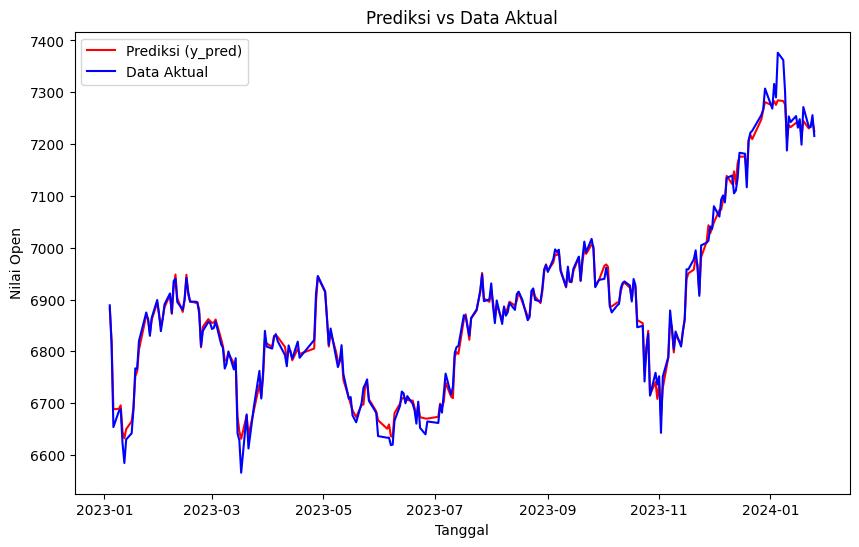

In [18]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, train_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [19]:
import catboost as cb
import optuna

In [20]:
def objective(trial):

    param = {
        'iterations': 1500,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 1.0, 2.0),
        "objective": trial.suggest_categorical("objective", ["MAPE", "RMSE"]),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "use_best_model": True,
        "task_type": "GPU",
        'random_seed': 42
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        


    gbm = cb.CatBoostRegressor(**param)

    gbm.fit(X_train_scaled, train_data["Open(t)"],eval_set=eval_pool,early_stopping_rounds=10,verbose=False)

    preds = gbm.predict(X_val_scaled)
    mse = np.mean((preds - validation_data['Open(t)'])**2)

    # Menghitung Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return rmse

In [21]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, timeout=600,gc_after_trial=True)

[I 2024-04-30 17:21:50,613] A new study created in memory with name: no-name-05b44c96-68a1-4fd2-8387-0198994da699
C:\Users\rizki\AppData\Local\Temp\ipykernel_24240\567742026.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 1.0),
C:\Users\rizki\AppData\Local\Temp\ipykernel_24240\567742026.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
[I 2024-04-30 17:21:50,993] Trial 0 finished with value: 289.3003717592212 and parameters: {'learning_rate': 0.9715389535708576, 'l2_leaf_reg': 1.0215027679225077, 'random_strength': 1.2413593475967404, 'ob

: 

In [ ]:
y_val_pred = model_catboost.predict(X_val_scaled)

In [ ]:
mse = np.mean((y_val_pred - validation_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 101612.6768169678
RMSE: 318.76743374593303


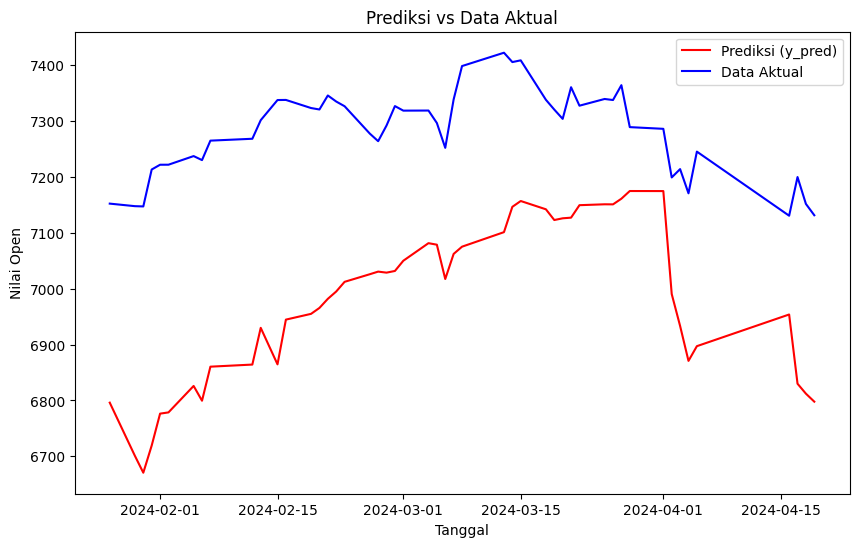

In [ ]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred, label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()